In [2]:
from typing import Tuple
import torch.utils.data as data
import torchvision.transforms as T
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import pandas as pd
import matplotlib.pyplot as plt
from max import locate_data, load_data
from bence import compare_images, augment_images_plain,augment_five_crop
from bence import augment_perspective

In [3]:

class SemanticSegmentationDataset(data.Dataset):
    def __init__(self, data_path: str):
        self.data_path = Path(data_path)
        (
            self.class_labels,
            self.X_train_paths,
            self.y_train_paths,
            self.X_test_paths,
            self.y_test_paths,
            self.X_val_paths,
            self.y_val_paths,
        ) = locate_data(self.data_path)


        # load original training set
        self.X_train_orig  = self.load_data(self.X_train_paths)
        self.y_train_orig = self.load_data(self.y_train_paths)

        print(self.X_train_orig.shape)
        # flip all images and add to training set
        X_train_flipped, y_train_flipped = self.flip_images(self.X_train_orig, self.y_train_orig)
        self.X_train = torch.cat((self.X_train_orig, X_train_flipped),0)
        self.y_train = torch.cat((self.y_train_orig, y_train_flipped),0)
        print('flipped')
        # five crop images with no_augmentations = 10 and add to training set
        X_train_crop, y_train_crop = self.five_crop_images(self.X_train_orig, self.y_train_orig, no_augmentations=10)
        self.X_train = torch.cat((self.X_train, X_train_crop),0)
        self.y_train = torch.cat((self.y_train, y_train_crop),0)
        print('cropped')
        # augment_perspective no_aumentaions = 20 and add to training set
        X_train_persp, y_train_persp = self.augment_perspective(self.X_train_orig, self.y_train_orig, no_augmentations=20)
        self.X_train = torch.cat((self.X_train, X_train_persp),0)
        self.y_train = torch.cat((self.y_train, y_train_persp),0)
        print('perspective')
        # T.ColorJitter(brightness=(1,2),hue=(-0.2,0.5),0) with augment_images_plain 5 times on 10 images and add to training set
        X_train_jittered, y_train_jittered = self.augment_images_plain(self.X_train_orig, self.y_train_orig, 
                                                                       T.ColorJitter(brightness=(1,2),hue=(-0.2,0.5)),
                                                                       no_augmentations=5)
        self.X_train = torch.cat((self.X_train, X_train_jittered),0)
        self.y_train = torch.cat((self.y_train, y_train_jittered),0)
        print('jittered1')
        X_train_jittered, y_train_jittered = self.augment_images_plain(self.X_train_orig, self.y_train_orig, 
                                                                       T.ColorJitter(brightness=(1,2),hue=(-0.2,0.5)),
                                                                       no_augmentations=5)
        self.X_train = torch.cat((self.X_train, X_train_jittered),0)
        self.y_train = torch.cat((self.y_train, y_train_jittered),0)
        print('jittered2')
        X_train_jittered, y_train_jittered = self.augment_images_plain(self.X_train_orig, self.y_train_orig, 
                                                                       T.ColorJitter(brightness=(1,2),hue=(-0.2,0.5)),
                                                                       no_augmentations=5)
        self.X_train = torch.cat((self.X_train, X_train_jittered),0)
        self.y_train = torch.cat((self.y_train, y_train_jittered),0)
        print('jittered3')

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        X = self.X_train[index]
        y = self.y_train[index]
        y = np.array(y)
        y = self.adjust_mask(y)
        y = torch.tensor(y)
        y = torch.squeeze(y)

        return X, y

    def __len__(self) -> int:
        return len(self.X_train)

    def load_data(self,file_paths: list[Path]) -> np.ndarray:
        """Load images into memory with uint8 dtype (format PyTorch likes"""
        array= np.array([np.array(Image.open(x), dtype=np.uint8) for x in file_paths])
        tensor = torch.from_numpy(array).permute(0,3,1,2)
        return tensor
    

    def flip_images(self,X: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Flip images horizontally"""
        X_flipped = torch.flip(X, dims=[3])
        y_flipped = torch.flip(y, dims=[3])
        return X_flipped, y_flipped
    
    def five_crop_images(self,X: torch.Tensor, y: torch.Tensor, no_augmentations = 10,crop_size = (360, 480)) -> Tuple[torch.Tensor, torch.Tensor]:
        """Five crop images"""
        five_cropper = T.FiveCrop(size=crop_size)
        resizer = T.Resize((720, 960))
        samples = np.random.randint(X.shape[0], size = no_augmentations)
        X_cropped = five_cropper(X[samples])
        y_cropped = five_cropper(y[samples])
        X_cropped = torch.cat([resizer(x) for x in X_cropped])
        y_cropped = torch.cat([resizer(x) for x in y_cropped])
        return X_cropped, y_cropped
    
    def augment_perspective(self,X: torch.Tensor, y: torch.Tensor, distortions_scale= 0.6,p = 1.0, no_augmentations = 20) -> Tuple[torch.Tensor, torch.Tensor]:
        """Augment perspective"""
        samples = np.random.randint(X.shape[0], size = no_augmentations)
        perspective = T.RandomPerspective(distortion_scale=distortions_scale, p=1.0)
        joint_tensor = torch.cat([X[samples], y[samples]])
        joint_tensor = perspective(joint_tensor)
        X_persp = joint_tensor[:no_augmentations]
        y_persp = joint_tensor[no_augmentations:]
        return X_persp, y_persp
    
    def augment_images_plain(self,X: torch.Tensor, y: torch.Tensor, transform: T, no_augmentations = 5) -> Tuple[torch.Tensor, torch.Tensor]:
        """Augment images with plain augmentation"""
        samples = np.random.randint(X.shape[0], size = no_augmentations)
        X_augmented = transform(X[samples])
        y_augmented = y[samples]

        return X_augmented, y_augmented
    
    def adjust_mask(self,mask: torch.Tensor, class_labels: pd.DataFrame) -> torch.Tensor:
        """Adjust mask to be in range 0-11"""
        label_dict = class_labels.iloc[:, 1:].to_dict(orient='index')
        label_dict ={ k: list(v.values()) for k, v in label_dict.items()}
        segmentation_map_list = []
        for x,color in enumerate(label_dict.values()):
            segmentation_map = (mask==color).all(axis=-1)
            segmentation_map=(segmentation_map*1)
            segmentation_map*=x
            segmentation_map_list.append(segmentation_map)
            
        return np.amax(np.stack(segmentation_map_list,axis=-1),axis=-1)



    



In [4]:
DATA_DIR = Path("../data/CamVid/")
dataset = SemanticSegmentationDataset(DATA_DIR)

torch.Size([369, 3, 720, 960])
flipped


/home/bence/.cache/pypoetry/virtualenvs/image-segmentation-QN7uw8Fi-py3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


cropped
perspective
jittered1
jittered2
jittered3


In [7]:
dataset.X_train.shape, dataset.y_train.shape

(torch.Size([823, 3, 720, 960]), torch.Size([823, 3, 720, 960]))

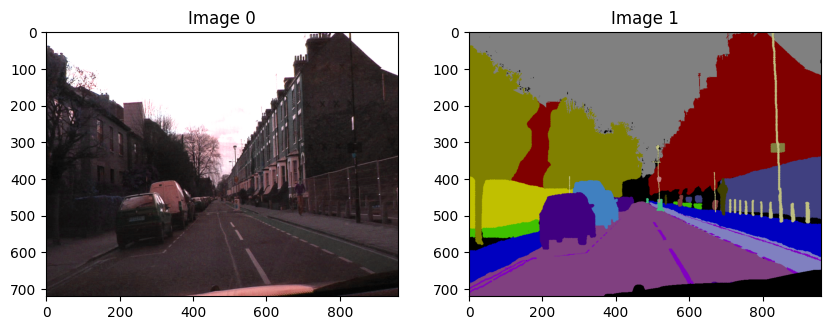

In [17]:
idx = 820
compare_images([dataset.X_train[idx].permute(1,2,0).numpy(), dataset.y_train[idx].permute(1,2,0).numpy()])

In [21]:
dataset.X_train[idx].permute(1,2,0).shape, dataset.y_train[idx].shape

(torch.Size([720, 960, 3]), torch.Size([3, 720, 960]))

In [24]:
dataset.X_train[idx].permute(1,2,0).numpy().shape

(720, 960, 3)

In [26]:
dataset.y_train[idx].permute(1,2,0).numpy().shape

(720, 960, 3)

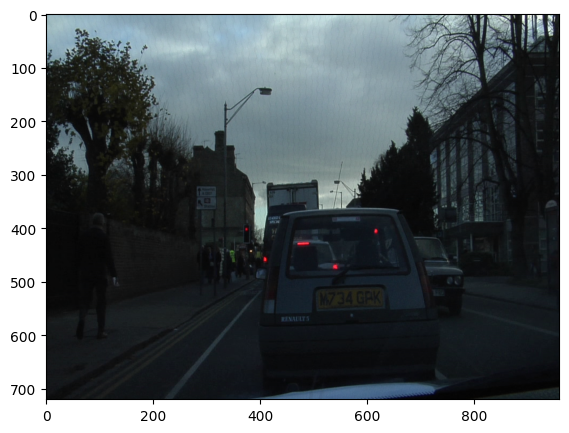

In [30]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
img_idx = 0
ax1.imshow(dataset.X_train[img_idx].permute(1,2,0).numpy())

